# Heat Stress Project - Milk Yield

# R Packages

In [1]:
suppressPackageStartupMessages({
  library(mgcv)
  library(arrow)
  library(dplyr)
  library(tictoc)
  library(fixest)
  library(plm)
  library(lspline)
  library(lmerTest)
  library(ggplot2)
  library(car)
  library(tidyverse)
  library(lmtest)
  library(rsample)
  library(rlang)
})
options(width=1000)

# Experiment Parameters

In [2]:
set.seed(2024)
period <- 1980:2023
month <- 4:10
start <- min(period)
stop <- max(period)
subsample <- F
diagnostic <- F
save <- F
sample_size <- 100000
dependent_var <- "milk_fpcm"
weather_var <- "thi_max_t2"
breeds <- c("HO", "JE", "SI", "SF", "BS", "OB")
start_knot <- 55
stop_knot <- 70
concatenated_string <- paste0("17_reduced_form_model_thi_mean_t0_3d_fixed_effect_", start, "-", stop, "_", format(Sys.time(), "%Y_%m_%d_%H_%M_%S"), "_", dependent_var)
concatenated_string

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1980-2023_2024_06_30_19_18_43_milk_fpcm"

# Custom Functions

In [3]:
generate_diagnostic_plots <- function(model) {
  # Extract fitted values and residuals
  fitted_values <- fitted(model)
  residuals <- residuals(model)
  
  # Create a data frame for plotting
  plot_data <- data.frame(fitted_values = fitted_values, residuals = residuals)
  print(nrow(plot_data))
  
  # Residuals vs Fitted Values Plot / Linearity & Homoscedacity
  p1 <- ggplot(plot_data, aes(x = fitted_values, y = residuals)) +
    geom_point(alpha = 0.5) +                       # Scatter plot of residuals
    geom_smooth(method = "loess", col = "red", se = FALSE) +    # Smooth curve (loess)
    labs(title = "Residuals vs. Fitted Values",
         x = "Fitted Values",
         y = "Residuals") +
    theme_minimal() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "blue")
  
  # Normal distribution of residuals
  p2 <- ggplot(plot_data, aes(sample = residuals)) +
    stat_qq() +
    stat_qq_line() +
    labs(title = "Normal Q-Q",
         x = "Theoretical Quantiles",
         y = "Residuals") +
    theme_minimal()
  
  # Scale-Location Plot (Homoscedacity - normally distributed standard error)
  plot_data$std_residuals <- scale(residuals)
  plot_data$abs_sqrt_residuals <- sqrt(abs(plot_data$std_residuals))
  
  p3 <- ggplot(plot_data, aes(fitted_values, abs_sqrt_residuals)) +
    geom_point() +
    geom_smooth(method = "loess", col = "red", se = FALSE) +
    labs(title = "Scale-Location Plot",
         x = "Fitted values",
         y = "√|Standardized residuals|") +
    theme_minimal()

  p4 <- ggplot(plot_data, aes(x = residuals)) +
    geom_histogram(binwidth = 0.5, fill = "blue", color = "black") +
    labs(title = "Histogram of Residuals", x = "Residuals", y = "Frequency") +
    theme_minimal()
 
  # Return the plots as a list
  list(
    Residuals_vs_Fitted = p1,
    Normal_QQ = p2,
    Scale_Location = p3,
    Residual_hist = p4
  )
}

In [4]:
create_effect_plot <- function(data, model, knot, response_var, predictor_var, breed) {
  # Create the range for the predictor variable
  predictor_range <- seq(ceiling(min(data[predictor_var], na.rm = TRUE)), floor(max(data[predictor_var], na.rm = TRUE)))
  # Calculate the effect
  effect <- lspline(predictor_range, knots = knot) %*% coeftest(model)[,1][1:(length(knot)+1)]
  
  # Calculate the confidence intervals
  effect_error_min <- effect - ((lspline(predictor_range, knots = knot)) %*% (abs(coeftest(model)[,2][1:(length(knot)+1)] * 1.96)))
  effect_error_max <- effect + ((lspline(predictor_range, knots = knot)) %*% (abs(coeftest(model)[,2][1:(length(knot)+1)] * 1.96)))
  
  # Create the data frame for plotting
  data_plot <- data.frame(
    breed = breed,
    predictor_range, 
    Effect = effect, 
    Lower = effect_error_min, 
    Upper = effect_error_max
  )
  
  # Create the plot
  plot <- ggplot(data_plot, aes(x = predictor_range, y = Effect)) +
    geom_line(color = "blue") +
    geom_ribbon(aes(ymin = Lower, ymax = Upper), alpha = 0.3, fill = "blue") +
    labs(
      title = paste("Effect of", predictor_var, "with Confidence Intervals"),
      x = paste(predictor_var, "Range"),
      y = "Effect"
    ) +
    theme_minimal() + 
    scale_x_continuous(breaks = seq(40, 90, by = 10), limits = c(40, max(predictor_range))) +
    theme(
      plot.title = element_text(hjust = 0.5),
      plot.title.position = "plot",
      axis.title.x = element_text(hjust = 0.5),
      axis.title.y = element_text(hjust = 0.5)
    )
  
  return(list(plot = plot, data = data_plot))
}

merge_plot_data <- function(plot_data_list) {
  # Combine the data frames from each plot into one data frame
  merged_data <- bind_rows(plot_data_list)
  
  return(merged_data)
}

# Load Data

In [5]:
milk_data <- read_parquet("/home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/12_base_data.parquet")

In [6]:
milk_data$animalBreedCode <- as.factor(milk_data$animalBreedCode)
milk_data$milk_fpcm <- milk_data$milk*(0.0337 + 0.116*milk_data$fat + 0.06*milk_data$protein)
milk_data$year <- as.factor(milk_data$year)
milk_data$farmId <- as.factor(milk_data$farmId)
milk_data$month <- as.factor(milk_data$month)
milk_data$logmilk <- log(milk_data$milk)
milkingMehtod <- as.factor(milk_data$milkingMethod)
milk_data$zip <- as.factor(milk_data$zip)
milk_data$days_in_milk <- as.numeric(milk_data$days_in_milk)
milk_data$days_in_milk <- milk_data$days_in_milk / 86400
milk_data$farm_year_interaction = interaction(milk_data$farmId, milk_data$year)
milk_data$farm_month_interaction = interaction(milk_data$farmId, milk_data$month)

milk_data$regular_season <- with(milk_data, 
    ifelse(month %in% c("3", "4", "5"), "spring",
    ifelse(month %in% c("6", "7", "8"), "summer",
    ifelse(month %in% c("9", "10", "11"), "fall", "winter"))))

# Convert the new variable to a factor
milk_data$regular_season <- as.factor(milk_data$regular_season)
milk_data$zip_regular_season <- interaction(milk_data$zip, milk_data$regular_season)

# Create the interaction term between farmId and month_range
milk_data$farmId_regular_season_interaction <- interaction(milk_data$farmId, milk_data$regular_season)

milk_data$farm_season <- with(milk_data, 
    ifelse(month %in% c("4", "5", "6", "7", "8", "9"), "grazing", "nongrazing"))

# Convert the new variable to a factor
milk_data$farm_season <- as.factor(milk_data$farm_season)

# Create the interaction term between farmId and farm_seasons
milk_data$farmId_farm_season_interaction <- interaction(milk_data$farmId, milk_data$farm_season)

In [7]:
milk_data <- subset(milk_data, year %in% period)
milk_data <- subset(milk_data, month %in% month)

In [8]:
if (subsample) { 
    milk_data <- milk_data %>%
      group_by(year, animalBreedCode) %>%
      sample_frac(sample_size/nrow(milk_data)) %>% drop_na(get(weather_var))
}

In [9]:
milk_data <- droplevels(milk_data)

split data for each breed

In [10]:
je <- droplevels(subset(milk_data, animalBreedCode %in% c("JE")) %>% drop_na(!!weather_var))
bs <- droplevels(subset(milk_data, animalBreedCode %in% c("BS")) %>% drop_na(!!weather_var))
ho <- droplevels(subset(milk_data, animalBreedCode %in% c("HO")) %>% drop_na(!!weather_var))
ob <- droplevels(subset(milk_data, animalBreedCode %in% c("OB")) %>% drop_na(!!weather_var))
si <- droplevels(subset(milk_data, animalBreedCode %in% c("SI")) %>% drop_na(!!weather_var))
sf <- droplevels(subset(milk_data, animalBreedCode %in% c("SF")) %>% drop_na(!!weather_var))

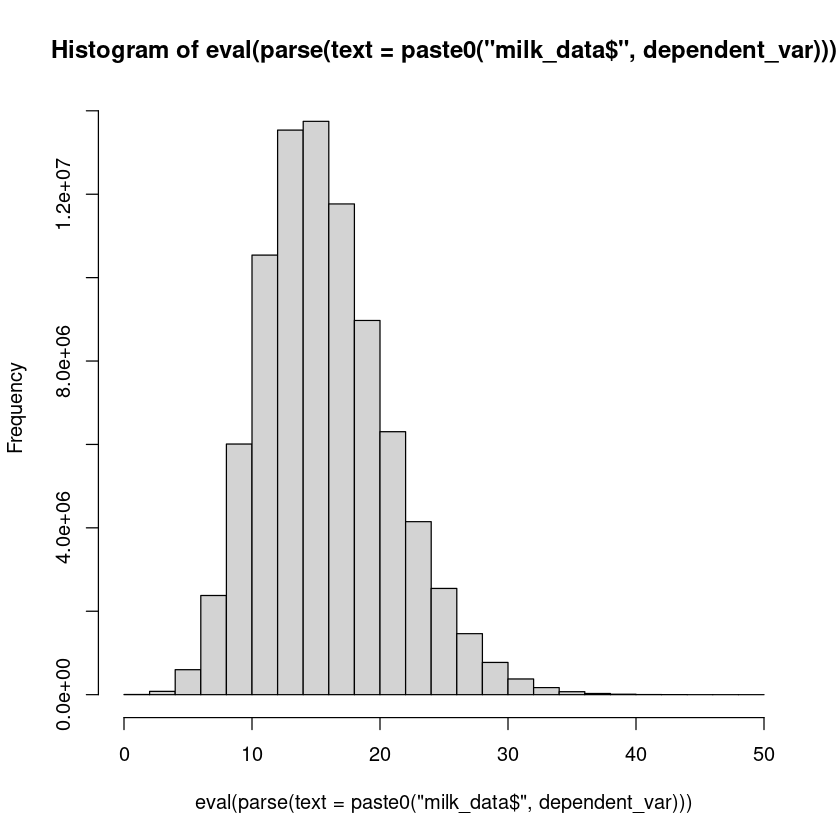

In [11]:
hist(eval(parse(text = paste0("milk_data$", dependent_var))))

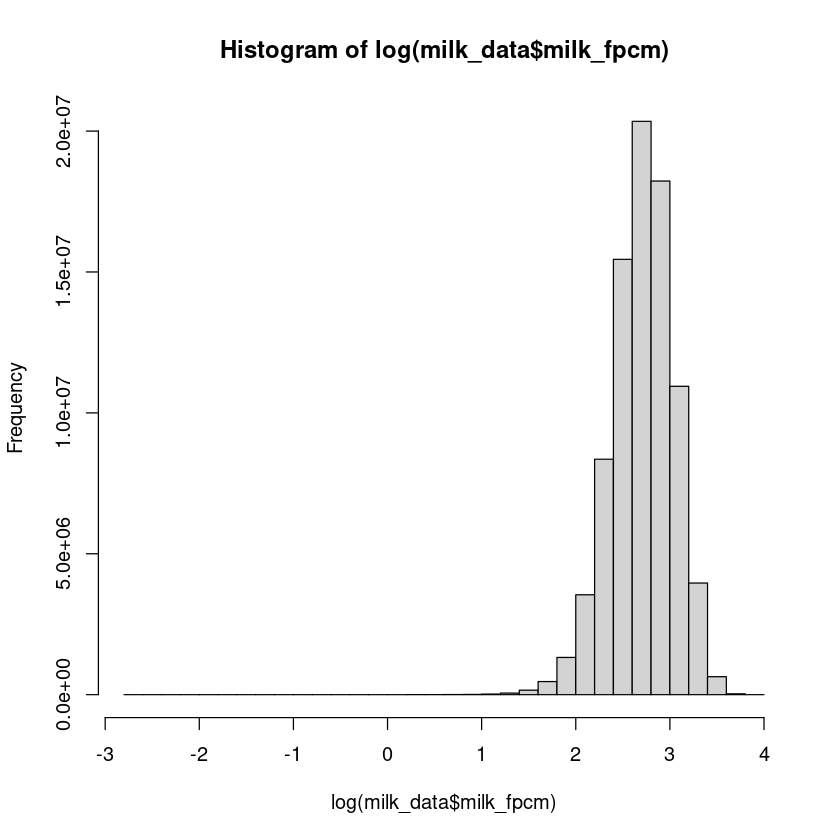

In [12]:
hist(log(milk_data$milk_fpcm))

In [13]:
rm(milk_data)

# Piecewise Linear THI - Reduced Form Piecewise Linear Fixed Effect Model

In [14]:
pl_clu <- c("year", "farmId")

run_models_with_knots <- function(data, knot_sequence, dep_var_name, weather_var) {
  best_rss <- Inf
  best_knot_comb <- NULL
  
  # Loop over each knot value
  for (i in 1:length(knot_sequence)) {
    knots <- paste(knot_sequence[[i]], collapse = ",")
    
    f <- paste0(dep_var_name, "~", "lspline(", weather_var, ", knots=c(", knots, ")) + days_in_milk + lactationNumber + precip_mean_t0_3d + precip_mean_t0_3d^2 + year | farmId")
    pl_form <- as.formula(f)
    model <- feols(pl_form, data = data, cluster = pl_clu)
    
    # Calculate RSS for the current model
    current_rss <- sum(residuals(model)^2)
    
    # Check if this model has the lowest RSS so far
    if (current_rss < best_rss) {
      best_rss <- current_rss
      best_knot_comb <- knot_sequence[[i]]
    }
  }
  
  # Recompute the best model for storage reasons
  knots <- paste(best_knot_comb, collapse = ",")
  f <- paste0(dep_var_name, "~", "lspline(", weather_var, ", knots=c(", knots, ")) + days_in_milk + lactationNumber + precip_mean_t0_3d + precip_mean_t0_3d^2 + year | farmId")
  pl_form <- as.formula(f)
  best_model <- feols(pl_form, data = data, cluster = pl_clu, lean = T)
  gc()
  
  # Return a list containing the best knot combination, the best model, and its RSS
  return(list(best_knot = best_knot_comb, best_model_rss = best_rss, best_model = best_model))
}



In [15]:
knot_combs <- list()
for (i in start_knot:stop_knot) {
    j <- i - start_knot + 1
  knot_combs[[j]] <- c(50,i)
}

In [16]:
#knot_combs[[length(knot_combs)+1]] <- seq(from = 0, to = 80, by = 5)

## Jersey

In [17]:
tic()
je_model = run_models_with_knots(droplevels(je), knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

19.349 sec elapsed


In [18]:
jersey_model_name <- paste0(concatenated_string, "_jersey_model.Rdata")
jersey_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1980-2023_2024_06_30_19_18_43_milk_fpcm_jersey_model.Rdata"

In [19]:
if (save) {
    tic()
    saveRDS(je_model, file = jersey_model_name, compress=T)
    toc()
}

In [20]:
je_model$best_knot

[1] 50 62

In [21]:
summary(je_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 660,110
Fixed-effects: farmId: 4,629
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(50, 62))1 -0.000739   0.002698  -0.273913 7.8650e-01    
lspline(thi_max_t2, knots = c(50, 62))2 -0.007882   0.006146  -1.282500 2.1192e-01    
lspline(thi_max_t2, knots = c(50, 62))3 -0.064409   0.005470 -11.775047 1.8474e-11 ***
days_in_milk                            -0.016692   0.000480 -34.767374  < 2.2e-16 ***
lactationNumber                          0.548944   0.014589  37.627395  < 2.2e-16 ***
precip_mean_t0_3d                       -0.002987   0.005579  -0.535435 5.9728e-01    
I(precip_mean_t0_3d^2)                  -0.000270   0.000196  -1.378424 1.8079e-01    
year2000                                -0.020110   0.028544  -0.704542 4.8788e-01    
year2001                                 1.029451   0.020039  51.372380  < 2.2e-16 **

Warning message:
“Removed 39 rows containing missing values or values outside the scale range (`geom_line()`).”


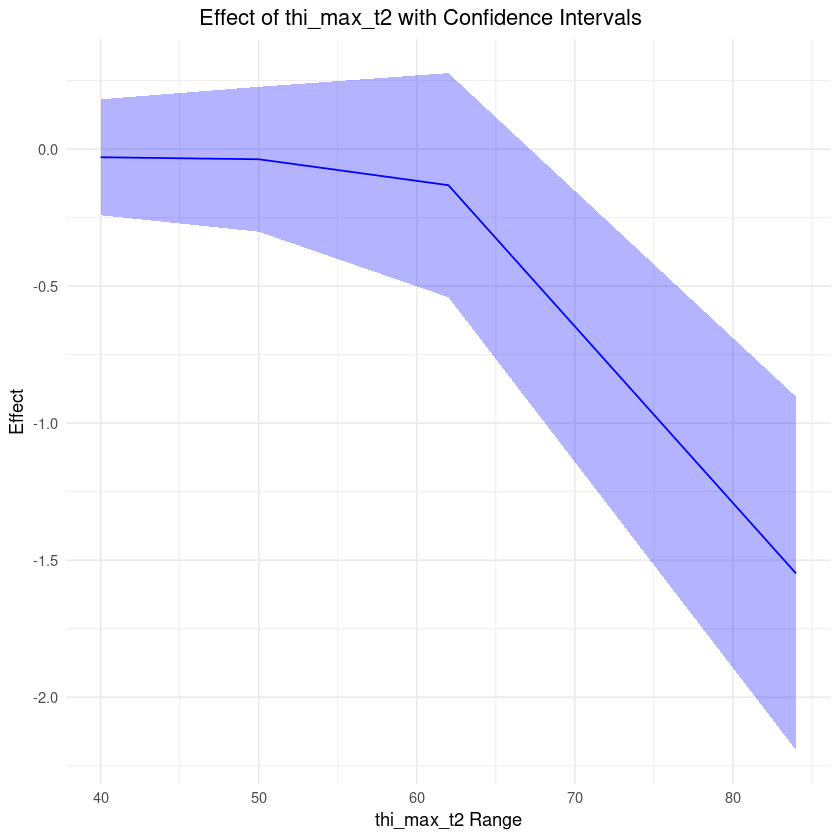

In [22]:
je_p <- create_effect_plot(je, je_model$best_model, je_model$best_knot, dependent_var, weather_var, "JE")
je_p$plot

## Holstein

In [23]:
tic()
ho_model = run_models_with_knots(ho, knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

519.761 sec elapsed


In [24]:
ho_model_name <- paste0(concatenated_string, "_ho_model.Rdata")
ho_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1980-2023_2024_06_30_19_18_43_milk_fpcm_ho_model.Rdata"

In [25]:
if (save) {
    tic()
    saveRDS(ho_model, file = ho_model_name, compress=TRUE)
    toc()
}

In [26]:
ho_model$best_knot

[1] 50 61

In [27]:
summary(ho_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 23,564,938
Fixed-effects: farmId: 25,742
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value  Pr(>|t|)    
lspline(thi_max_t2, knots = c(50, 61))1 -0.001825   0.002042  -0.893818   0.37878    
lspline(thi_max_t2, knots = c(50, 61))2 -0.006881   0.002945  -2.336042   0.02661 *  
lspline(thi_max_t2, knots = c(50, 61))3 -0.064752   0.003608 -17.947300 < 2.2e-16 ***
days_in_milk                            -0.024952   0.000495 -50.397025 < 2.2e-16 ***
lactationNumber                          0.687691   0.008247  83.385274 < 2.2e-16 ***
precip_mean_t0_3d                        0.002309   0.004490   0.514141   0.61105    
I(precip_mean_t0_3d^2)                  -0.000235   0.000167  -1.402672   0.17133    
year1995                                 0.278341   0.014104  19.734852 < 2.2e-16 ***
year1996                                 0.440597   0.008897  49.519458 < 2.2e-16 ***
year

Warning message:
“Removed 41 rows containing missing values or values outside the scale range (`geom_line()`).”


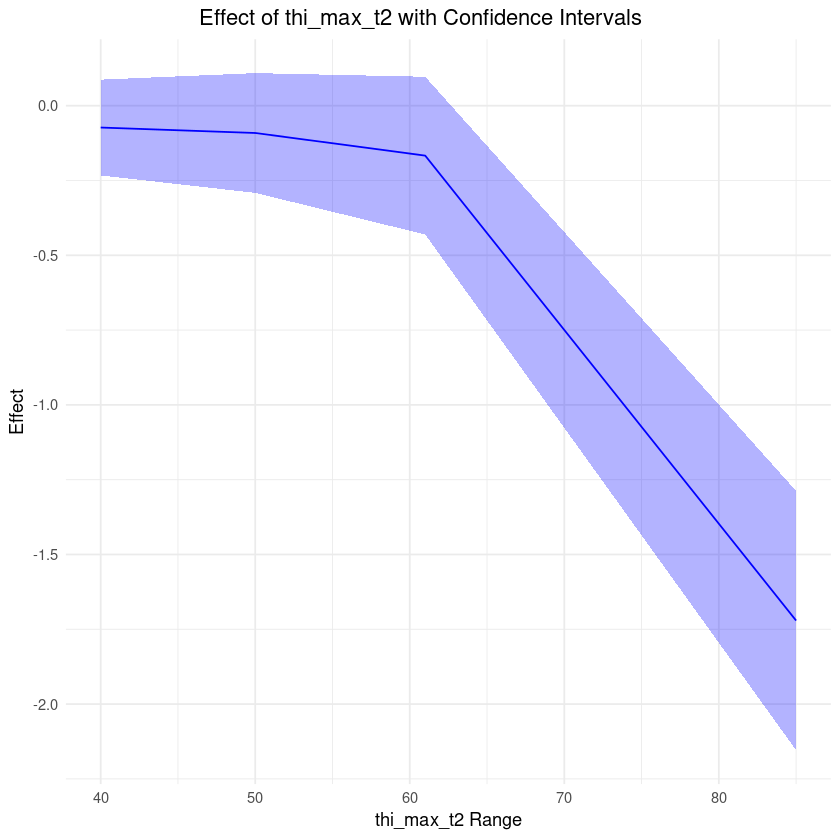

In [28]:
ho_p <- create_effect_plot(ho, ho_model$best_model, ho_model$best_knot, dependent_var, weather_var, "HO")
ho_p$plot

## Brown Swiss

In [29]:
tic()
bs_model = run_models_with_knots(bs, knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

794.434 sec elapsed


In [30]:
bs_model_name <- paste0(concatenated_string, "_bs_model.Rdata")
bs_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1980-2023_2024_06_30_19_18_43_milk_fpcm_bs_model.Rdata"

In [31]:
if (save) {
    tic()
    saveRDS(bs_model, file = bs_model_name, compress=T)
    toc()
}

In [32]:
bs_model$best_knot

[1] 50 61

In [33]:
summary(bs_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 34,763,300
Fixed-effects: farmId: 22,610
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(50, 61))1 -0.003109   0.001628  -1.910097 6.5118e-02 .  
lspline(thi_max_t2, knots = c(50, 61))2 -0.011228   0.003179  -3.531762 1.2779e-03 ** 
lspline(thi_max_t2, knots = c(50, 61))3 -0.042845   0.003682 -11.636971 4.9044e-13 ***
days_in_milk                            -0.020651   0.000403 -51.281724  < 2.2e-16 ***
lactationNumber                          0.443804   0.009392  47.255879  < 2.2e-16 ***
precip_mean_t0_3d                       -0.004008   0.002722  -1.472503 1.5065e-01    
I(precip_mean_t0_3d^2)                  -0.000011   0.000095  -0.118929 9.0608e-01    
year1992                                 0.163299   0.013520  12.078647 1.8455e-13 ***
year1993                                 0.078310   0.007885   9.931177 2.6837e-1

Warning message:
“Removed 41 rows containing missing values or values outside the scale range (`geom_line()`).”


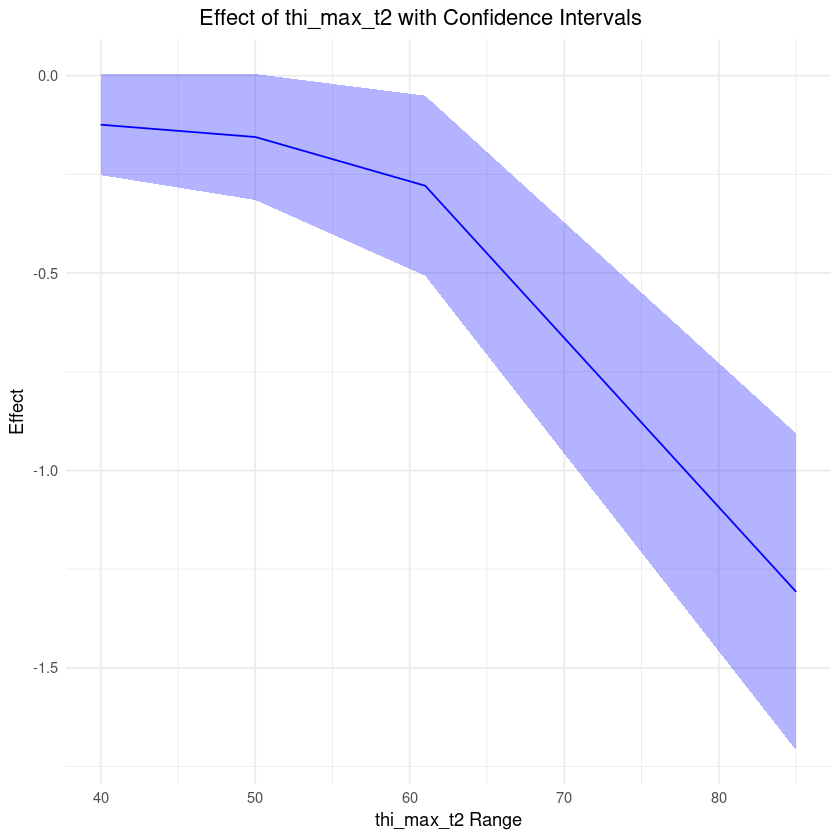

In [34]:
bs_p <- create_effect_plot(bs, bs_model$best_model, bs_model$best_knot, dependent_var, weather_var, "BS")
bs_p$plot

## Simmental

In [35]:
tic()
si_model = run_models_with_knots(si, knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

97.509 sec elapsed


In [36]:
si_model_name <- paste0(concatenated_string, "_si_model.Rdata")
si_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1980-2023_2024_06_30_19_18_43_milk_fpcm_si_model.Rdata"

In [37]:
if (save) {
    tic()
    saveRDS(si_model, file = si_model_name, compress=T)
    toc()
}

In [38]:
si_model$best_knot

[1] 50 62

In [39]:
summary(si_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 4,510,321
Fixed-effects: farmId: 15,044
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(50, 62))1  0.005845   0.001864    3.13578 4.0038e-03 ** 
lspline(thi_max_t2, knots = c(50, 62))2  0.010415   0.003069    3.39380 2.0754e-03 ** 
lspline(thi_max_t2, knots = c(50, 62))3 -0.046435   0.004014  -11.56949 3.5097e-12 ***
days_in_milk                            -0.022044   0.000142 -154.98908  < 2.2e-16 ***
lactationNumber                          0.430408   0.007036   61.16968  < 2.2e-16 ***
precip_mean_t0_3d                        0.009172   0.003707    2.47426 1.9677e-02 *  
I(precip_mean_t0_3d^2)                  -0.000454   0.000153   -2.97415 5.9878e-03 ** 
year1996                                 0.015986   0.008943    1.78740 8.4702e-02 .  
year1997                                 0.447225   0.005694   78.54530  < 2.2e-16

Warning message:
“Removed 39 rows containing missing values or values outside the scale range (`geom_line()`).”


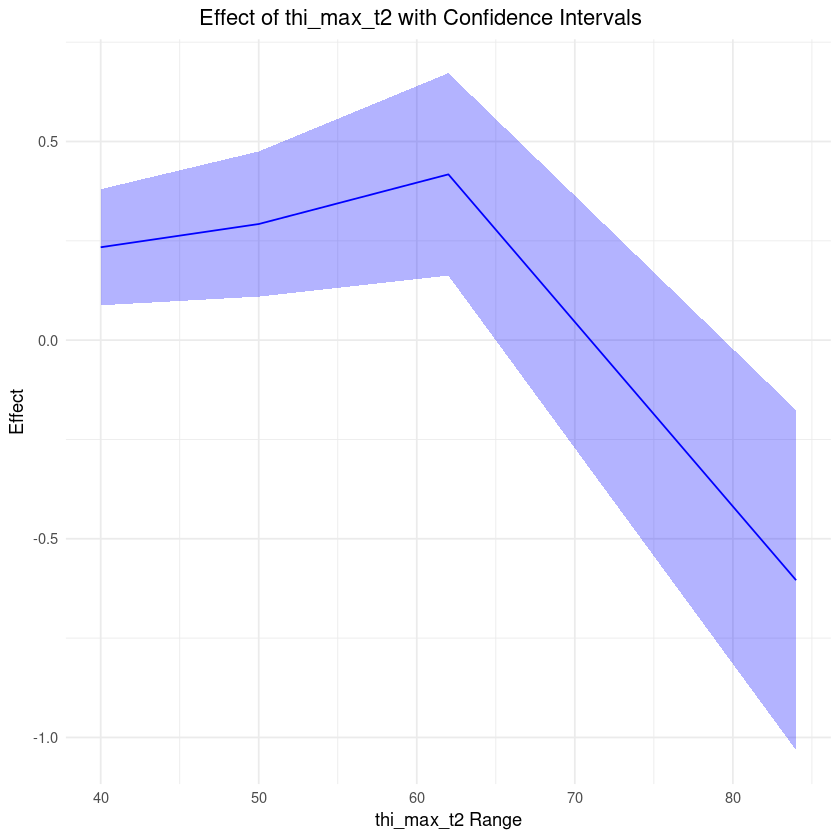

In [40]:
si_p <- create_effect_plot(si, si_model$best_model, si_model$best_knot, dependent_var, weather_var, "SI")
si_p$plot

## Swiss Fleckvieh

In [41]:
tic()
sf_model = run_models_with_knots(sf, knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

385.662 sec elapsed


In [42]:
sf_model_name <- paste0(concatenated_string, "_sf_model.Rdata")
sf_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1980-2023_2024_06_30_19_18_43_milk_fpcm_sf_model.Rdata"

In [43]:
if (save) {
    tic()
    saveRDS(sf_model, file = sf_model_name, compress=T)
    toc()
}

In [44]:
sf_model$best_knot

[1] 50 62

In [45]:
summary(sf_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 18,075,998
Fixed-effects: farmId: 28,014
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(50, 62))1  0.006671   0.002408   2.770372 9.6679e-03 ** 
lspline(thi_max_t2, knots = c(50, 62))2  0.010172   0.003061   3.323188 2.4176e-03 ** 
lspline(thi_max_t2, knots = c(50, 62))3 -0.054802   0.003323 -16.493551 2.8333e-16 ***
days_in_milk                            -0.025738   0.000334 -77.077861  < 2.2e-16 ***
lactationNumber                          0.499543   0.011990  41.662638  < 2.2e-16 ***
precip_mean_t0_3d                        0.002916   0.003296   0.884866 3.8351e-01    
I(precip_mean_t0_3d^2)                  -0.000151   0.000124  -1.217115 2.3337e-01    
year1995                                 0.329178   0.005537  59.455909  < 2.2e-16 ***
year1996                                 0.546885   0.003669 149.066302  < 2.2e-1

Warning message:
“Removed 41 rows containing missing values or values outside the scale range (`geom_line()`).”


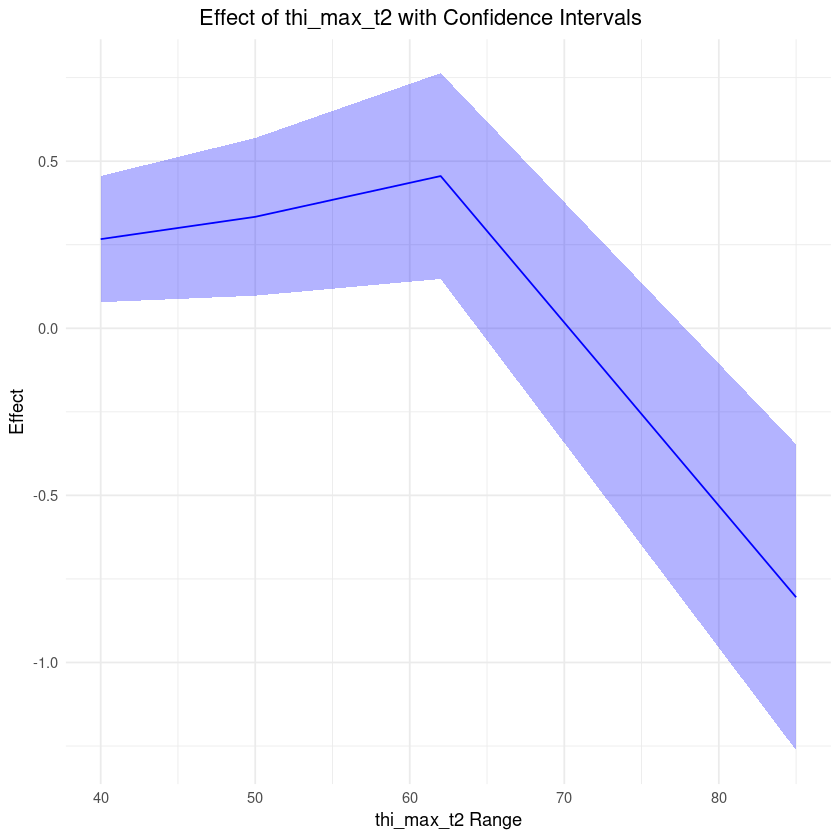

In [46]:
sf_p <- create_effect_plot(sf, sf_model$best_model, sf_model$best_knot, dependent_var, weather_var, "SF")
sf_p$plot

# Original Braunvieh

In [47]:
tic()
ob_model = run_models_with_knots(ob, knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

56.342 sec elapsed


In [48]:
ob_model_name <- paste0(concatenated_string, "_ob_model.Rdata")
ob_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1980-2023_2024_06_30_19_18_43_milk_fpcm_ob_model.Rdata"

In [49]:
if (save) {
    tic()
    saveRDS(ob_model, file = ob_model_name, compress=T)
    toc()
}

In [50]:
ob_model$best_knot

[1] 50 61

In [51]:
summary(ob_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 1,956,438
Fixed-effects: farmId: 8,591
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(50, 61))1 -0.001185   0.001810  -0.654919 5.1720e-01    
lspline(thi_max_t2, knots = c(50, 61))2  0.004154   0.002761   1.504306 1.4231e-01    
lspline(thi_max_t2, knots = c(50, 61))3 -0.035456   0.003682  -9.630330 5.6514e-11 ***
days_in_milk                            -0.019663   0.000202 -97.431213  < 2.2e-16 ***
lactationNumber                          0.388020   0.013697  28.328063  < 2.2e-16 ***
precip_mean_t0_3d                        0.002509   0.003755   0.668033 5.0890e-01    
I(precip_mean_t0_3d^2)                  -0.000141   0.000143  -0.988725 3.3022e-01    
year1992                                 0.178223   0.017672  10.084807 1.8432e-11 ***
year1993                                 0.036078   0.006080   5.934088 1.3137e-06 

Warning message:
“Removed 40 rows containing missing values or values outside the scale range (`geom_line()`).”


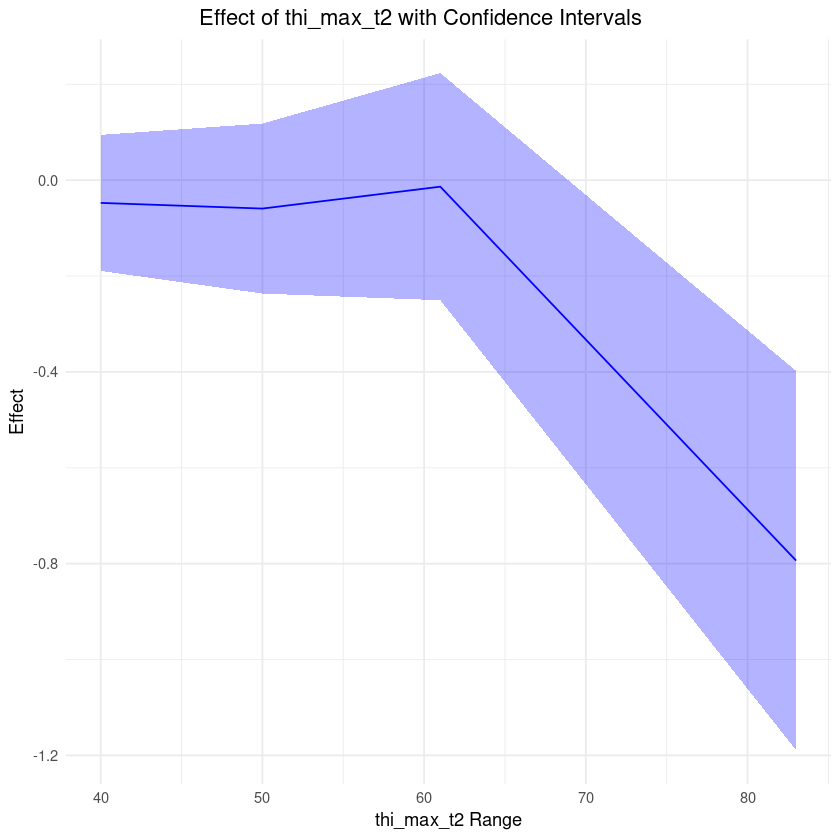

In [52]:
ob_p <- create_effect_plot(ob, ob_model$best_model, ob_model$best_knot, dependent_var, weather_var, "OB")
ob_p$plot

## Merge data

In [53]:
breed_effect_data <- merge_plot_data(list(ho_p$data, bs_p$data, sf_p$data, si_p$data, bs_p$data, je_p$data, ob_p$data))
saveRDS(ob_model, file = paste0(concatenated_string, "_plot_data.Rdata"), compress=T)

In [54]:
# Function to plot merged data
plot_merged_data <- function(merged_data, predictor_var) {
  # Create the plot
    
    y_min <- min(merged_data$Lower)
    y_max <- max(merged_data$Upper)
    plot <- ggplot(merged_data, aes(x = predictor_range, y = Effect, color = breed, fill = breed)) +
    geom_line() +
    geom_ribbon(aes(ymin = Lower, ymax = Upper), alpha = 0.3) +
    labs(
      title = paste0("Effect of", predictor_var, " per breed"),
      x = "Predictor Variable Range",
      y = "Effect"
    ) +
    theme_minimal() +
    scale_x_continuous(breaks = seq(40,  max(merged_data$predictor_range), by = 10), limits = c(40, max(merged_data$predictor_range))) +
    scale_y_continuous(limits = c(y_min, y_max)) +
    theme(
      plot.title = element_text(hjust = 0.5),
      plot.title.position = "plot",
      axis.title.x = element_text(hjust = 0.5),
      axis.title.y = element_text(hjust = 0.5)
    ) +
    facet_wrap(~ breed)
  
  
  return(plot)
}

Warning message:
“Removed 282 rows containing missing values or values outside the scale range (`geom_line()`).”


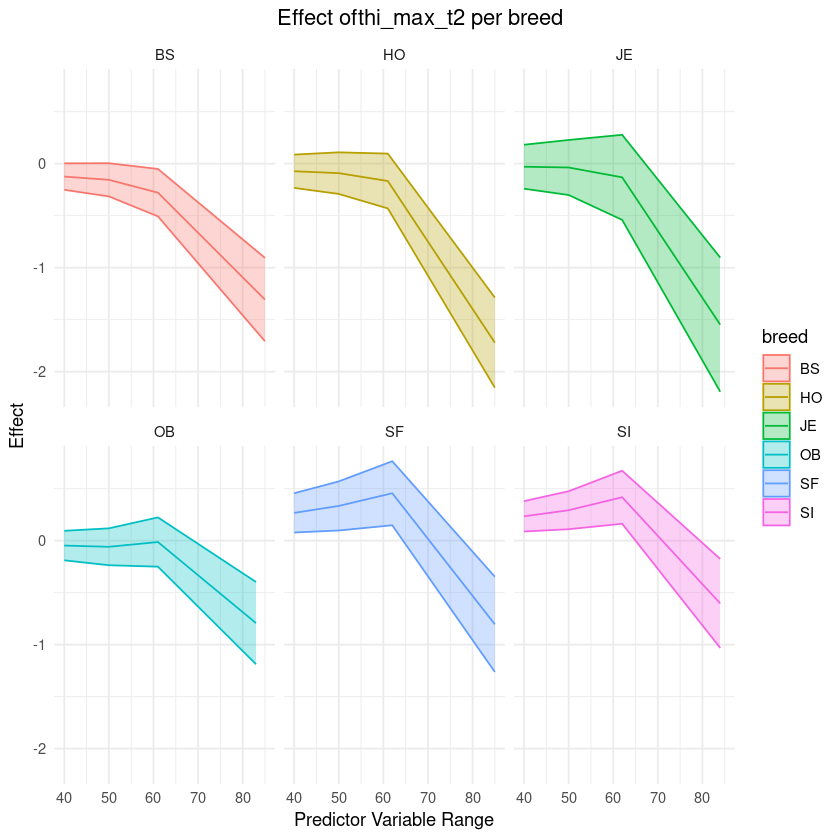

In [55]:
plot_merged_data(breed_effect_data, weather_var)